## 웨이스킨 피부수분지수 예측 프로젝트 

PPT 자료 다운로드 : 
https://drive.google.com/drive/folders/16XbtPdCD2PYF3aFGgGBzdaJSW93yT3p_?usp=sharing 


#### 패키지 로딩 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
import statsmodels.api as sm
import warnings

# 옵션설정
set_matplotlib_formats("retina")

# 행, 열은 500개까지 display 설정
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

plt.rc('font', family="AppleGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

#### 데이터 로딩 

In [2]:
path = "downloads/"
df = pd.read_csv(path + 'data.csv')

#### 데이터 확인

In [3]:
print(df.shape)
df.head(3)

(67086, 43)


,USER_ID,sex,birthDate,Age,periodCycle,periodDay,periodStartDay,recommend_waterIntake,location.latitude,location.longitude,location.city_id,location.ko,skintype.type,skintype.pigment,skintype.wrinkle,skintype.pore,skintype.sensitive,skintype.skin_age,skintype.keyword,피부측정날짜,피부측정시간,피부수분지수,측정위치위도,측정위치경도,기기측정온도,기기측정습도,기기측정자외선,피부측정위치,메이크업상태,장소,측정시(hour),측정시간대,생리주기단계,uv,min_temp,max_temp,min_humidity,max_humidity,min_pressure,max_pressure,min_feelslike,max_feelslike,current_condition
0,iVLZEtwNAr,Female,19670727.0,53,28.0,5.0,NaN,1761.0,38.901379,-76.985619,4140963,워싱턴,natural,0.0,2.0,0.0,0.0,16.0,NRNWS,2018-01-12,10:52,77.95,38.89567,-77.021030,25.926603,54.01236,0.01,forehead,makeup,home,10.0,morning,NaN,1.0,6.0,15.0,78.0,100.0,1006.0,1019.0,6.0,16.0,흐린
1,iVLZEtwNAr,Female,19670727.0,53,28.0,5.0,NaN,1761.0,38.901379,-76.985619,4140963,워싱턴,natural,0.0,2.0,0.0,0.0,16.0,NRNWS,2018-01-12,10:52,64.95,38.89567,-77.021030,26.321814,54.17716,0.01,cheek,makeup,home,10.0,morning,NaN,1.0,6.0,15.0,78.0,100.0,1006.0,1019.0,6.0,16.0,흐린
2,iVLZEtwNAr,Female,19670727.0,53,28.0,5.0,NaN,1761.0,38.901379,-76.985619,4140963,워싱턴,natural,0.0,2.0,0.0,0.0,16.0,NRNWS,2018-01-15,15:54,51.68,38.89571,-77.021065,24.554054,32.44831,0.01,cheek,makeup,home,15.0,afternoon,NaN,2.0,-7.0,-2.0,26.0,50.0,1029.0,1038.0,-11.0,-3.0,흐린


## 데이터 EDA 및 전처리 

In [4]:
# 날짜전처리
df["datetime"] = df["피부측정날짜"] + " " + df["피부측정시간"]
df["datetime"] = pd.to_datetime(df["datetime"])

#### 피부수분지수 분포

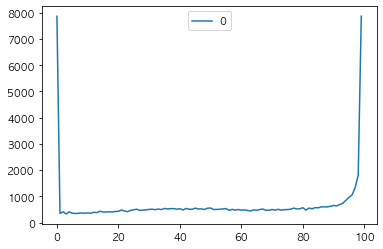

In [5]:
count_1 = []
i = 0
while i < 100:
    count_1.append(len(df[(df['피부수분지수'] >= i) & (df['피부수분지수'] < i + 1)]))
    i = i + 1
pd.DataFrame(count_1).plot()
plt.show()

In [6]:
pd.DataFrame(count_1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,7868,348,408,328,404,355,343,352,363,351,366,351,391,379,429,402,402,409,402,421,428,477,438,415,463,486,507,460,475,482,501,508,490,515,493,536,519,528,531,508,528,479,536,508,505,548,517,520,499,545,553,496,500,507,519,532,466,499,473,497,470,479,463,438,484,467,497,513,466,469,494,474,503,472,491,494,507,549,518,525,564,475,552,521,569,561,599,597,597,618,652,633,686,738,847,960,1052,1332,1805,7871


#### 10미만 90 이하 값은 제거

In [7]:
outlier = (df['피부수분지수'] < 10) | (df['피부수분지수'] > 90)
df_nonoutlier = df[~outlier]
df_nonoutlier.shape

(39375, 44)

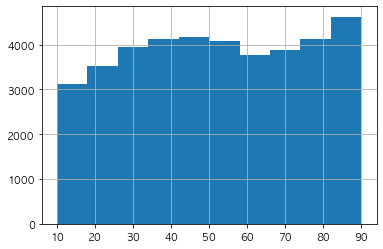

In [8]:
df_nonoutlier["피부수분지수"].hist()
plt.show()

#### 반복측정제거
- 한 시간 이내에 반복해서 측정한 경우 중위수 값으로 사용
- 데이터 개수가 24978개로 축소 

In [9]:
df_nonduple = df_nonoutlier.groupby(by=[
    '피부측정날짜', '측정시(hour)', 'USER_ID', 'sex', 'location.city_id',
    'skintype.type', '메이크업상태', '측정시간대', 'current_condition',
    'skintype.keyword', '피부측정위치', '장소', "datetime"
]).median()
df_nonduple.reset_index(inplace=True)

In [10]:
df_nonduple.shape

(29619, 42)

#### 추가 전처리
- 나이 이상치 제거 (오류값들을 전체 평균치인 33으로 정정)
- 계절 변수 추가

In [11]:
import math
def age_mean(x):
    if (x > 71) | (x < 10) :
        return 33
    else:
        return x
df_nonduple['Age'] = df_nonduple['Age'].map(age_mean)

pd.to_datetime(df_nonduple['피부측정날짜']).dt.month
df_nonduple['month'] = pd.to_datetime(df_nonduple.피부측정날짜).dt.month
df_nonduple['season'] = df_nonduple.month.replace([1,2,3,4,5,6,7,8,9,10,11,12],
['Winter','Winter','Spring','Spring','Spring','Summer','Summer','Summer','Fall','Fall','Fall','Winter'])

df_nonduple["피부측정날짜"] = pd.to_datetime(df_nonduple["피부측정날짜"],
                                      format='%Y-%m-%d %H:%M:%S',
                                      errors='raise')
df_nonduple["weekday"] = df_nonduple["피부측정날짜"].dt.weekday

#### 히스토그램 

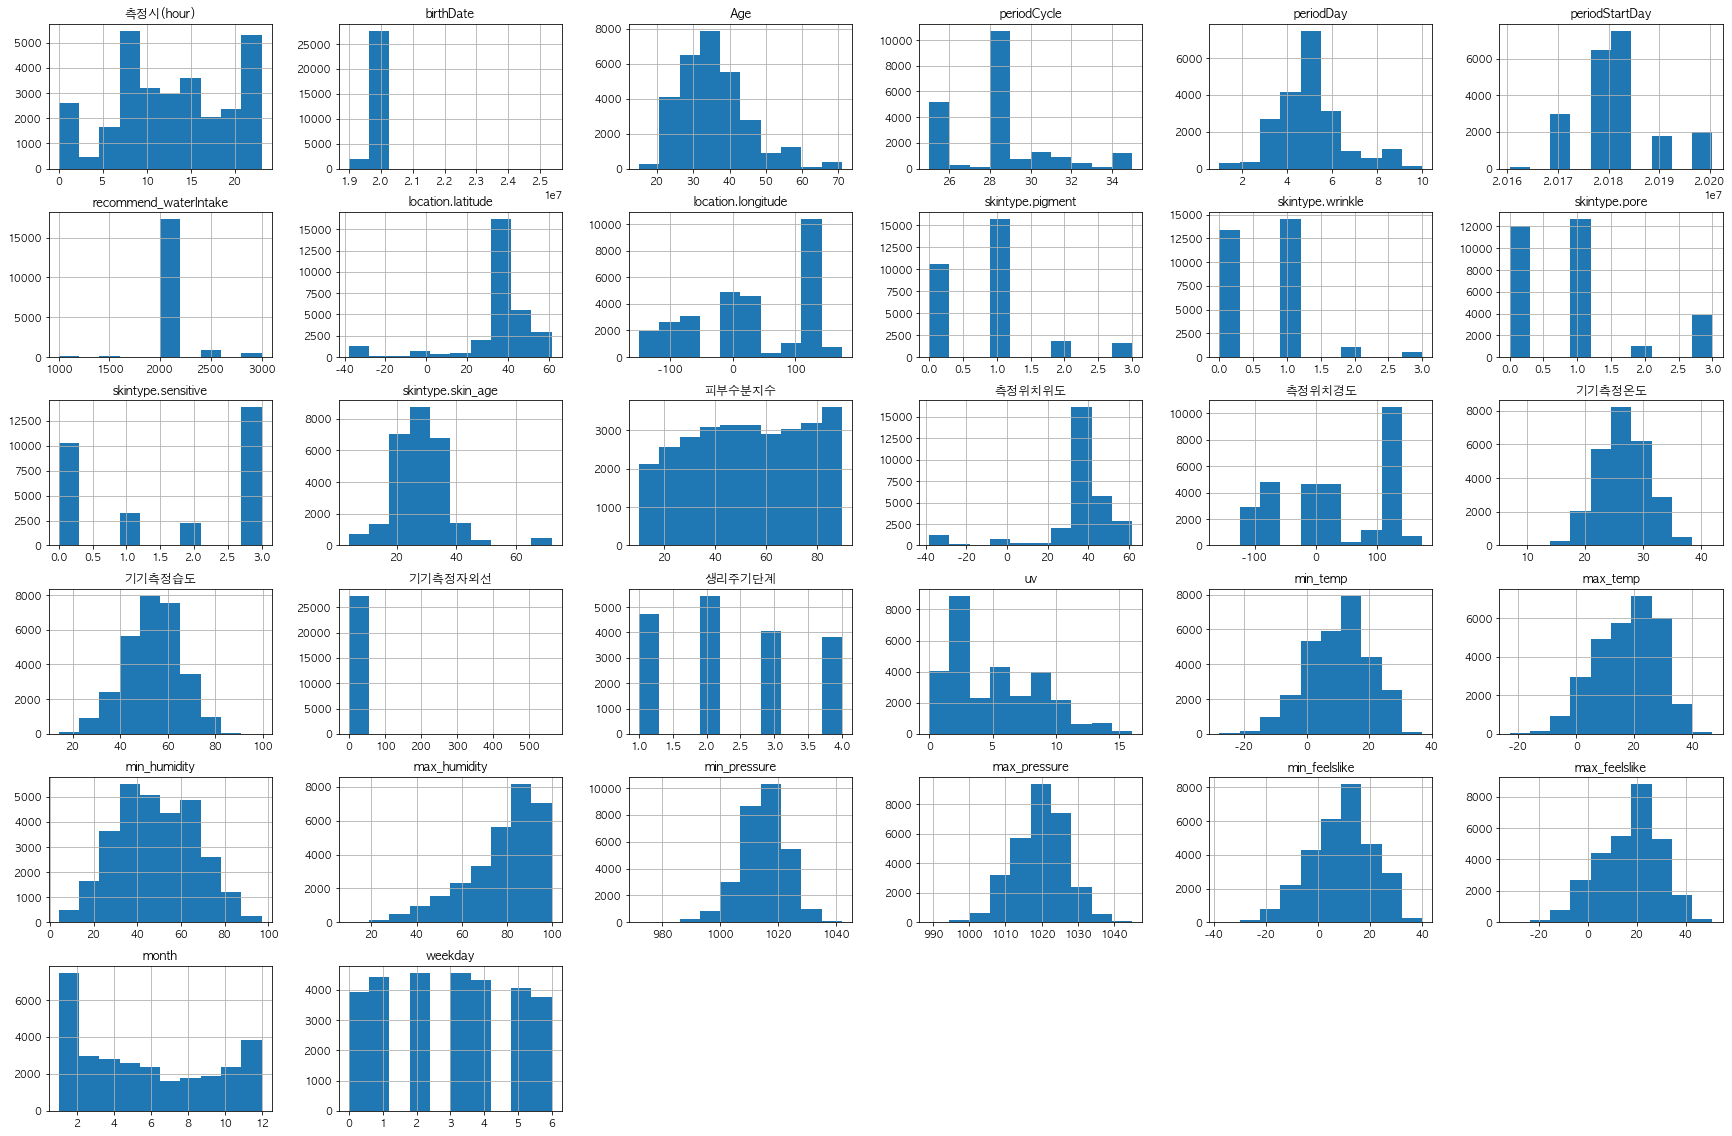

In [13]:
# 전체 변수 분포 
# 목표변수인 피부수분지수와 유사한 분포를 가진 독립변수가 있는지 check & 필요시 정규분포화, 로그 등 분포조정을 검토 
df_nonduple.hist(figsize = (30, 20))
plt.show()

### 각 변수별 수분 분포

* 측정 장소별 수분 분포

Text(0.5, 1.0, '수분지수 분포 by 측정장소')

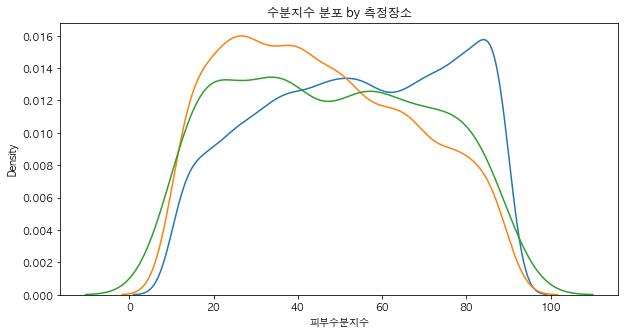

In [14]:
## 장소에 따른 수분변화
## home > outside > office 순으로 수분이 확연히 차이가 나는 것을 알 수 있다.

plt.subplots(figsize=(10, 5))
# KDE plot
sns.kdeplot(df_nonduple.loc[df_nonduple["장소"] == "home", '피부수분지수'], label="home")
sns.kdeplot(df_nonduple.loc[df_nonduple["장소"] == "office", '피부수분지수'], label="office")
sns.kdeplot(df_nonduple.loc[df_nonduple["장소"] == "outside", '피부수분지수'], label="outside")

# # Labeling of plot
plt.xlabel('피부수분지수')
plt.ylabel('Density')
plt.title('수분지수 분포 by 측정장소')

* 스킨케어 상태에 따른 수분 분포

Text(0.5, 1.0, '수분지수 분포 by 메이크업상태')

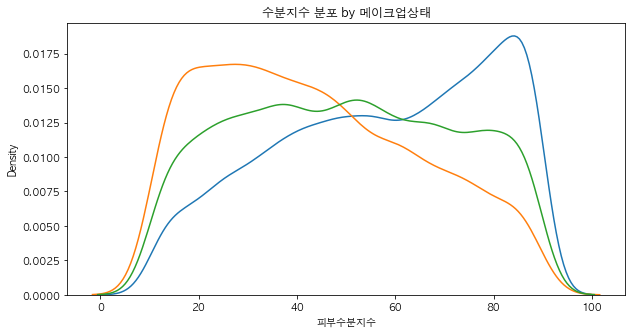

In [15]:
plt.subplots(figsize=(10, 5))
# KDE plot
sns.kdeplot(df_nonduple.loc[df_nonduple["메이크업상태"] == "skincare", '피부수분지수'],
            label="skincare")
sns.kdeplot(df_nonduple.loc[df_nonduple["메이크업상태"] == "makeup", '피부수분지수'],
            label="makeup")
sns.kdeplot(df_nonduple.loc[df_nonduple["메이크업상태"] == "nothing", '피부수분지수'],
            label="nothing")

# # Labeling of plot
plt.xlabel('피부수분지수')
plt.ylabel('Density')
plt.title('수분지수 분포 by 메이크업상태')

* 피부측정 위치별 수분 분포

Text(0.5, 1.0, '수분지수 분포 by 피부측정위치')

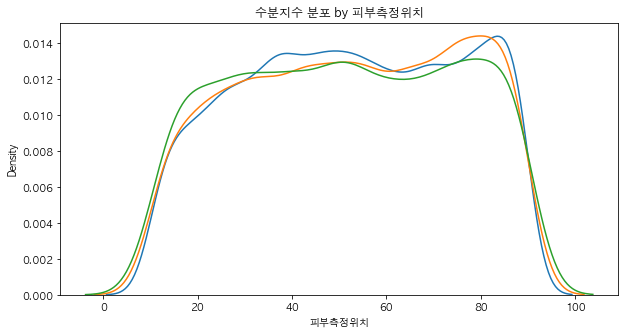

In [16]:
plt.subplots(figsize=(10, 5))
# KDE plot
sns.kdeplot(df_nonduple.loc[df_nonduple["피부측정위치"] == "cheek", '피부수분지수'],
            label="cheek")
sns.kdeplot(df_nonduple.loc[df_nonduple["피부측정위치"] == "forehead", '피부수분지수'],
            label="forehead")
sns.kdeplot(df_nonduple.loc[df_nonduple["피부측정위치"] == "etc", '피부수분지수'],
            label="etc")

# # Labeling of plot
plt.xlabel('피부측정위치')
plt.ylabel('Density')
plt.title('수분지수 분포 by 피부측정위치')

- 피부 측정위 볼, 노메이크업, 홈에서 측정한 데이터만 관찰 

In [17]:
df_fixed = df_nonduple[(df_nonduple["피부측정위치"] == "cheek") & (df_nonduple["메이크업상태"] == "nothing")
                & (df_nonduple["장소"] == "home")]

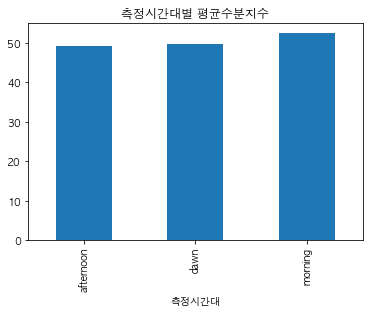

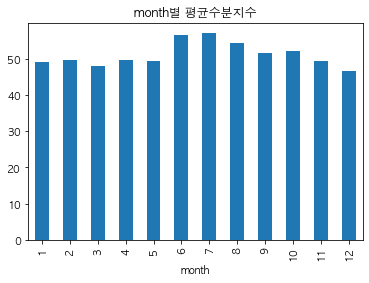

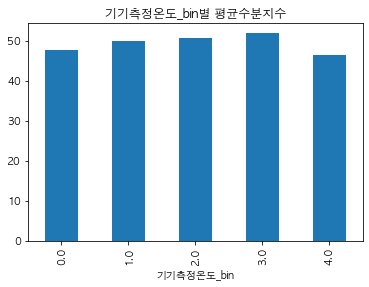

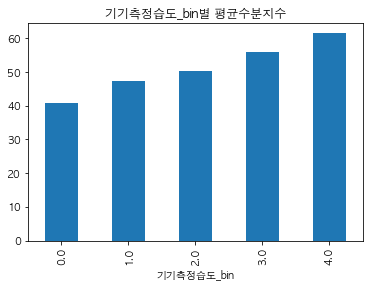

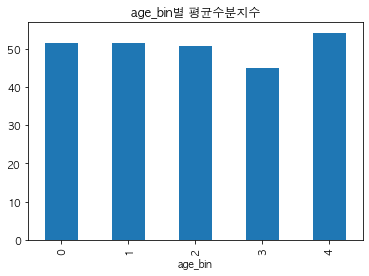

In [18]:
df_fixed["기기측정온도_bin"] = pd.cut(df_fixed["기기측정온도"], 5, labels=False)
df_fixed["기기측정습도_bin"] = pd.cut(df_fixed["기기측정습도"], 5, labels=False)
df_fixed["age_bin"] = pd.cut(df_fixed['Age'], 5, labels=False)

ft = [
    '측정시간대', 'month','기기측정온도_bin', '기기측정습도_bin',
    'age_bin'
]

for x in ft:
    plt.subplots()
    (df_fixed[[
        x, '피부수분지수'
    ]].groupby(x).피부수분지수.mean().plot.bar())
    plt.title(f"{x}별 평균수분지수")

<AxesSubplot:xlabel='season', ylabel='피부수분지수'>

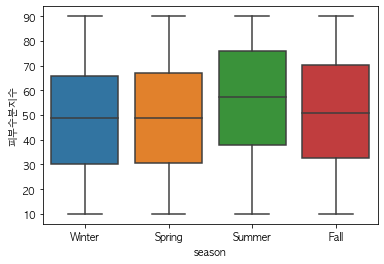

In [19]:
sns.boxplot(x='season', y='피부수분지수',data=df_fixed)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(1, 0, '25.0'),
  Text(2, 0, '26.0'),
  Text(3, 0, '27.0'),
  Text(4, 0, '28.0'),
  Text(5, 0, '29.0'),
  Text(6, 0, '30.0'),
  Text(7, 0, '31.0'),
  Text(8, 0, '32.0'),
  Text(9, 0, '33.0'),
  Text(10, 0, '34.0'),
  Text(11, 0, '35.0')])

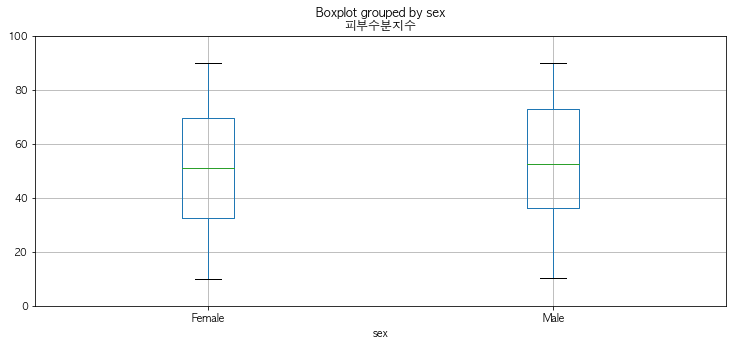

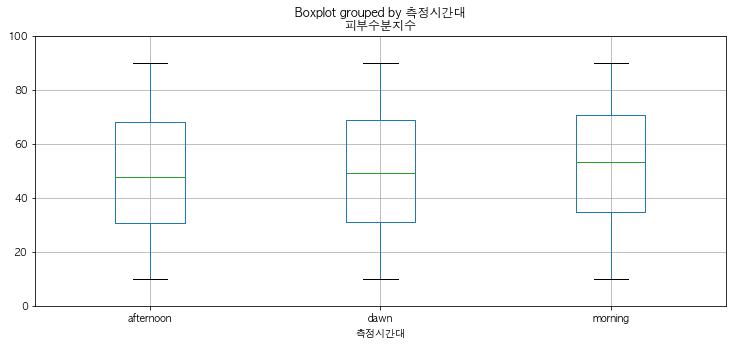

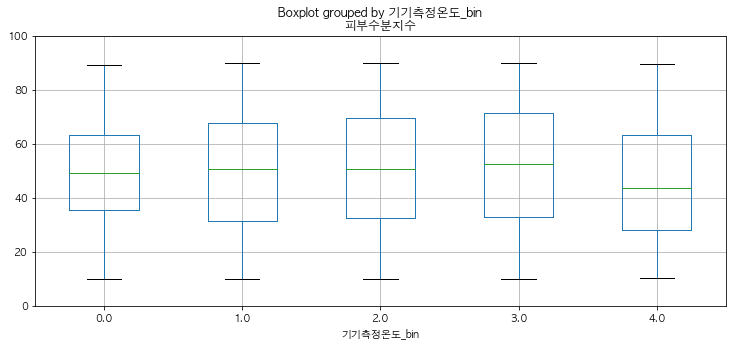

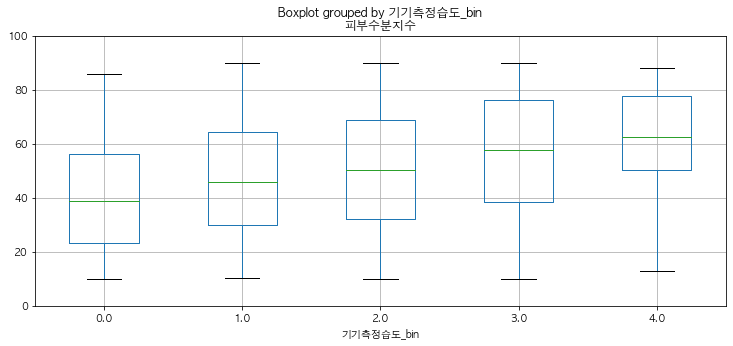

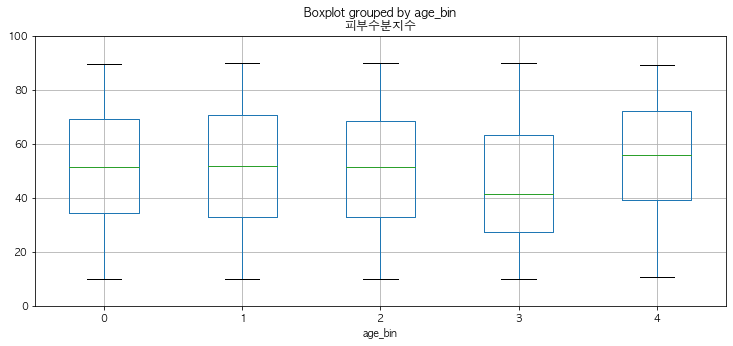

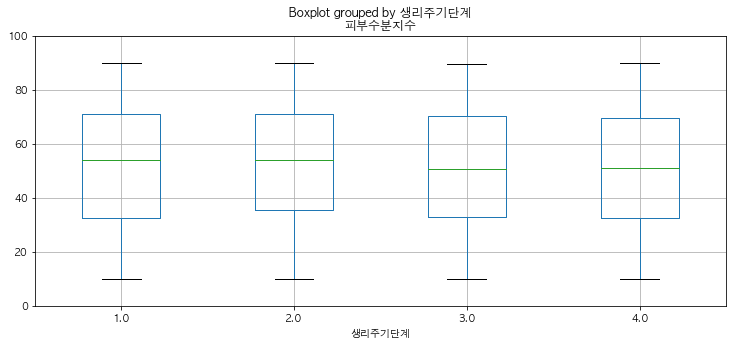

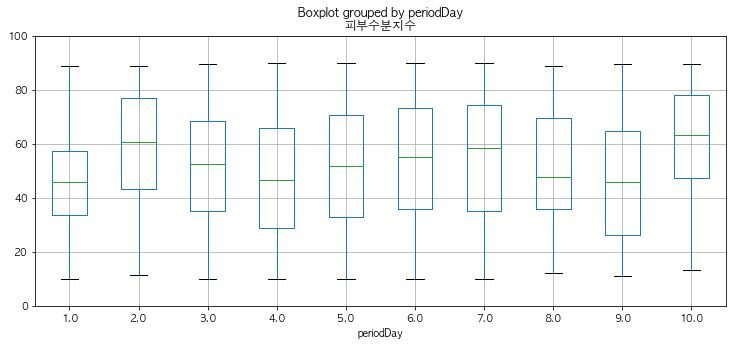

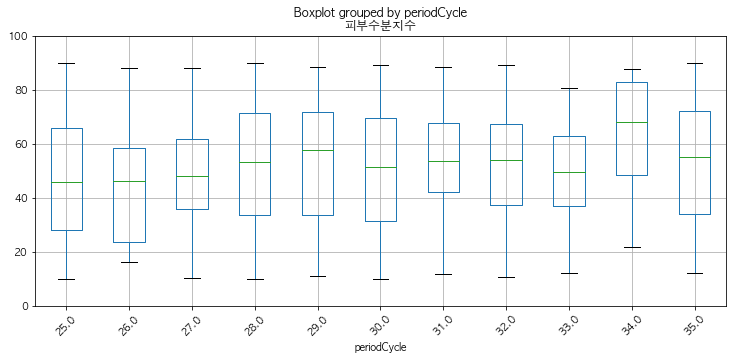

In [20]:
# box plot
df_fixed.boxplot(column='피부수분지수', by='sex', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='측정시간대', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='기기측정온도_bin', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='기기측정습도_bin', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='age_bin', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='생리주기단계', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='periodDay', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
df_fixed.boxplot(column='피부수분지수', by='periodCycle', grid=True, figsize=(12, 5))
plt.ylim(0, 100)
plt.xticks(rotation = 45)

#### 결측치 제거

In [23]:
var = ['USER_ID', 'sex', 'Age', 
       'location.latitude', 'location.longitude',
       'skintype.type', 'skintype.pigment', 'skintype.wrinkle',
       'skintype.pore', 'skintype.sensitive', 'skintype.skin_age',
       'skintype.keyword', '피부측정날짜', '피부수분지수', '메이크업상태', '측정시(hour)',
       '측정시간대', 'uv', 'min_temp', 'max_temp', '피부측정위치',
       'min_humidity', 'max_humidity', 'min_pressure', 'max_pressure',
       'current_condition', '기기측정온도', '기기측정습도', '기기측정자외선','season']

In [24]:
df_nonduple[var].isnull().describe().T.sort_values(by='freq')

,count,unique,top,freq
기기측정온도,29619,2,False,25964
skintype.skin_age,29619,2,False,26835
기기측정자외선,29619,2,False,27259
기기측정습도,29619,2,False,29019
skintype.wrinkle,29619,2,False,29533
skintype.pigment,29619,2,False,29609
USER_ID,29619,1,False,29619
current_condition,29619,1,False,29619
max_pressure,29619,1,False,29619
min_pressure,29619,1,False,29619


In [25]:
df_drop = df_nonduple[var].dropna(how='any')
df_drop.isnull().describe().T.sort_values(by='freq')

,count,unique,top,freq
USER_ID,21909,1,False,21909
기기측정습도,21909,1,False,21909
기기측정온도,21909,1,False,21909
current_condition,21909,1,False,21909
max_pressure,21909,1,False,21909
min_pressure,21909,1,False,21909
max_humidity,21909,1,False,21909
min_humidity,21909,1,False,21909
피부측정위치,21909,1,False,21909
max_temp,21909,1,False,21909


In [26]:
df_drop = df_drop.reset_index(drop=True)

유저별 라벨

In [27]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df_drop.USER_ID)
X_encoded = encoder.transform(df_drop.USER_ID)
USER_ID_label = pd.DataFrame(X_encoded)
df_drop = pd.concat((USER_ID_label,df_drop),axis=1)

In [28]:
df_drop.head()

,0,USER_ID,sex,Age,location.latitude,location.longitude,skintype.type,skintype.pigment,skintype.wrinkle,skintype.pore,skintype.sensitive,skintype.skin_age,skintype.keyword,피부측정날짜,피부수분지수,메이크업상태,측정시(hour),측정시간대,uv,min_temp,max_temp,피부측정위치,min_humidity,max_humidity,min_pressure,max_pressure,current_condition,기기측정온도,기기측정습도,기기측정자외선,season
0,254,5a45fc884a03f541f3c44058,Female,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,81.25,skincare,2.0,dawn,2.0,0.0,4.0,cheek,17.0,43.0,1025.0,1029.0,화창함,27.248417,34.879074,0.01,Winter
1,254,5a45fc884a03f541f3c44058,Female,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,61.71,skincare,2.0,dawn,2.0,0.0,4.0,etc,17.0,43.0,1025.0,1029.0,화창함,28.486114,34.759288,0.01,Winter
2,254,5a45fc884a03f541f3c44058,Female,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,84.11,skincare,2.0,dawn,2.0,0.0,4.0,forehead,17.0,43.0,1025.0,1029.0,화창함,27.814528,35.317005,0.01,Winter
3,207,5a31350cc78945304f826c43,Female,35,35.14032,129.06780,combination,0.0,1.0,1.0,3.0,29.0,CSNTS,2018-01-01,27.69,skincare,7.0,morning,2.0,4.0,7.0,cheek,38.0,57.0,1025.0,1028.0,화창함,26.108187,46.660564,0.01,Winter
4,207,5a31350cc78945304f826c43,Female,35,35.14032,129.06780,combination,0.0,1.0,1.0,3.0,29.0,CSNTS,2018-01-01,27.53,skincare,7.0,morning,2.0,4.0,7.0,forehead,38.0,57.0,1025.0,1028.0,화창함,27.707714,48.917374,0.01,Winter


In [29]:
season = df_drop['season']
season_dummi = pd.get_dummies(season)
df_drop = pd.concat([df_drop, season_dummi],axis=1)

In [30]:
skintype = df_drop['skintype.type']
skintype_dummi = pd.get_dummies(skintype)
df_drop = pd.concat([df_drop, skintype_dummi],axis=1)

timebin = df_drop['측정시간대']
timebin_dummi = pd.get_dummies(timebin)
df_drop = pd.concat([df_drop, timebin_dummi],axis=1)

# period = TT_nothing['생리주기단계']
# period_dummi = pd.get_dummies(period,prefix="period_")
# TT_nothing = pd.concat([TT_nothing, period_dummi],axis=1)

makeup = df_drop['메이크업상태']
makeup_dummi = pd.get_dummies(makeup)
df_drop = pd.concat([df_drop, makeup_dummi],axis=1)

position = df_drop['피부측정위치']
position_dummi = pd.get_dummies(position)
df_drop = pd.concat([df_drop, position_dummi],axis=1)

In [31]:
df_drop['sex'] = df_drop['sex'].map(lambda x: 1 if x=='Female' else 0)
df_drop['weekday'] = pd.to_datetime(df_drop.피부측정날짜).dt.day_name()
weekday = pd.get_dummies(df_drop['weekday'])
df_drop = pd.concat((df_drop, weekday), axis=1)

In [32]:
df_drop.head()

,0,USER_ID,sex,Age,location.latitude,location.longitude,skintype.type,skintype.pigment,skintype.wrinkle,skintype.pore,skintype.sensitive,skintype.skin_age,skintype.keyword,피부측정날짜,피부수분지수,메이크업상태,측정시(hour),측정시간대,uv,min_temp,max_temp,피부측정위치,min_humidity,max_humidity,min_pressure,max_pressure,current_condition,기기측정온도,기기측정습도,기기측정자외선,season,Fall,Spring,Summer,Winter,combination,dry,natural,oily,afternoon,dawn,morning,makeup,nothing,skincare,cheek,etc,forehead,weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,254,5a45fc884a03f541f3c44058,1,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,81.25,skincare,2.0,dawn,2.0,0.0,4.0,cheek,17.0,43.0,1025.0,1029.0,화창함,27.248417,34.879074,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,Monday,0,1,0,0,0,0,0
1,254,5a45fc884a03f541f3c44058,1,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,61.71,skincare,2.0,dawn,2.0,0.0,4.0,etc,17.0,43.0,1025.0,1029.0,화창함,28.486114,34.759288,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,Monday,0,1,0,0,0,0,0
2,254,5a45fc884a03f541f3c44058,1,35,37.50951,127.05898,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,84.11,skincare,2.0,dawn,2.0,0.0,4.0,forehead,17.0,43.0,1025.0,1029.0,화창함,27.814528,35.317005,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,Monday,0,1,0,0,0,0,0
3,207,5a31350cc78945304f826c43,1,35,35.14032,129.06780,combination,0.0,1.0,1.0,3.0,29.0,CSNTS,2018-01-01,27.69,skincare,7.0,morning,2.0,4.0,7.0,cheek,38.0,57.0,1025.0,1028.0,화창함,26.108187,46.660564,0.01,Winter,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,Monday,0,1,0,0,0,0,0
4,207,5a31350cc78945304f826c43,1,35,35.14032,129.06780,combination,0.0,1.0,1.0,3.0,29.0,CSNTS,2018-01-01,27.53,skincare,7.0,morning,2.0,4.0,7.0,forehead,38.0,57.0,1025.0,1028.0,화창함,27.707714,48.917374,0.01,Winter,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,Monday,0,1,0,0,0,0,0


# Data 샘플링
- 30번 이상 측정 한 사람 대상으로 30개씩 추출

In [33]:
name_list=[]
for i in range(len(df_drop['USER_ID'].value_counts())):
    if df_drop['USER_ID'].value_counts()[i] >= 40:
        name_list.append(df_drop['USER_ID'].value_counts().index[i])

In [34]:
TF_list=[]
for i in range(len(df_drop)):
    TF_list.append(df_drop.iloc[i]['USER_ID'] in name_list)

In [35]:
df_drop_sampled = df_drop[TF_list]
sampled=pd.DataFrame()
for i in name_list:
    temp = df_drop_sampled[df_drop_sampled['USER_ID']==i].sample(n=30, random_state=123)
    sampled = pd.concat((sampled, temp))
#sampled['생리이후기'] = sampled['생리주기단계'].map(lambda x: 1 if x ==2 else 0)
sampled.shape

(3480, 56)

In [36]:
sampled = df_drop[TF_list]

In [37]:
sampled.shape

(13596, 56)

In [38]:
sampled['외부온도'] = (sampled['min_temp'] + sampled['max_temp'])/2
sampled['외부습도'] = (sampled['min_humidity'] + sampled['max_humidity'])/2
# sampled['AgeXcount'] = sampled['Age'] * sampled['0_y']
# sampled['AgeXMaxtemp'] = sampled['Age'] * sampled['max_temp']
sampled['온도차'] = abs(sampled['외부온도'] - sampled['기기측정온도'])
sampled['습도차'] = abs(sampled['외부습도'] - sampled['기기측정습도'])

In [39]:
var = ['Age','skintype.pore', 'skintype.sensitive', '측정시(hour)','기기측정온도','기기측정습도',
       'Fall','Summer', 'Winter', 'combination', 'dry','oily','afternoon', 'dawn','makeup','skincare',          
       'cheek','forehead',
       'Friday', 'Saturday','Sunday', 'Thursday','Tuesday','Wednesday',               
       '외부온도','온도차']

In [40]:
# var2 = [ 'Age', 'skintype.pore','외부온도','외부습도',
#        '기기측정온도', '기기측정습도', 'summer',
#         'dry',
#          'afternoon','dawn','makeup','skincare','온도차']
target = '피부수분지수'

In [41]:
X= sampled[var]
y= sampled[target]

In [42]:
import statsmodels.api as sm

X_con = sm.add_constant(X, has_constant='add')

multi_model = sm.OLS(y, X_con)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 피부수분지수   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     57.72
Date:                Wed, 10 Feb 2021   Prob (F-statistic):          1.52e-284
Time:                        15:10:56   Log-Likelihood:                -60865.
No. Observations:               13596   AIC:                         1.218e+05
Df Residuals:                   13569   BIC:                         1.220e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 36.8124      2.257     16.312      0.000      32.389      41.236
Age                   -0.1134      0.019     -6.018      0.000      -0.150      -0.076
skintype.pore         -1.3198      0.224     -5.903      0.000      -1.758      -0.882
skintype.sensitive     0.9610      0.155      6.204      0.000       0.657       1.265
측정시(hour)              0.0314      0.033      0.940      0.347      -0.034       0.097
기기측정온도                 0.0091      0.194      0.047      0.962      -0.372       0.390
기기측정습도                 0.1727      0.019      8.860      0.000       0.134       0.211
Fall                  -0.9057      0.518     -1.748      0.080      -1.921       0.110
Summer                 1.8671      0.601      3.107      0.002       0.689       3.045
Winter                 1.9960      0.529      3.775      0.000       0.960       3.032
combination            3.6389      0.493      7.388      0.000       2.673       4.604
dry                    7.2388      0.654     11.067      0.000       5.957       8.521
oily                   7.9772      0.858      9.295      0.000       6.295       9.659
afternoon             -1.6075      0.494     -3.252      0.001      -2.576      -0.639
dawn                   3.6570      0.497      7.364      0.000       2.684       4.630
makeup                -3.6346      0.590     -6.163      0.000      -4.791      -2.479
skincare               7.6508      0.440     17.377      0.000       6.788       8.514
cheek                  1.4213      0.621      2.288      0.022       0.204       2.639
forehead               0.6353      0.705      0.900      0.368      -0.748       2.018
Friday                -1.3525      0.690     -1.959      0.050      -2.706       0.001
Saturday              -1.1219      0.711     -1.578      0.115      -2.516       0.272
Sunday                 0.4453      0.715      0.623      0.533      -0.956       1.846
Thursday              -0.9599      0.685     -1.400      0.161      -2.303       0.384
Tuesday               -0.1676      0.682     -0.246      0.806      -1.504       1.169
Wednesday              0.0813      0.678      0.120      0.905      -1.248       1.410
외부온도                   0.1468      0.189      0.775      0.438      -0.224       0.518
온도차                   -0.0744      0.194     -0.383      0.702      -0.456       0.307
==============================================================================
Omnibus:                     2236.313   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.708
Skew:                          -0.082   Prob(JB):                    1.26e-111
Kurtosis:                       2.065   Cond. No.                         927.
==============================================================================

In [43]:
variables2 = var.copy()
fitted_multi_model.bic

121987.09277330912

In [44]:
## backward elimination을 통해 feature selection 수행 

aic = fitted_multi_model.bic
def backward(variables, aic):
    var=[]
    for i in variables:
        temp = variables.copy() 
        temp.remove(i)
        X_temp = sampled[temp]
        y_temp = sampled[target]
        X_temp_con = sm.add_constant(X_temp, has_constant='add')
        multi_model_temp = sm.OLS(y_temp, X_temp_con)
        fitted_multi_model_temp = multi_model_temp.fit()
        aic_temp = fitted_multi_model_temp.aic
        if aic_temp < aic:
            aic = aic_temp
            var = temp
    print('aic:',aic,var)
    print('removed:',list(set(variables) - set(var)))
    return var, aic
    
var2, aic2= backward(variables2, aic)
var3, aic3 = backward(var2, aic2)
var4, aic4 = backward(var3, aic3)
var5, aic5 = backward(var4, aic4)
var6, aic6 = backward(var5, aic5)
var7, aic7 = backward(var6, aic6)

aic: 121782.12166010571 ['Age', 'skintype.pore', 'skintype.sensitive', '측정시(hour)', '기기측정습도', 'Fall', 'Summer', 'Winter', 'combination', 'dry', 'oily', 'afternoon', 'dawn', 'makeup', 'skincare', 'cheek', 'forehead', 'Friday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '외부온도', '온도차']
removed: ['기기측정온도']
aic: 121780.13610409587 ['Age', 'skintype.pore', 'skintype.sensitive', '측정시(hour)', '기기측정습도', 'Fall', 'Summer', 'Winter', 'combination', 'dry', 'oily', 'afternoon', 'dawn', 'makeup', 'skincare', 'cheek', 'forehead', 'Friday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', '외부온도', '온도차']
removed: ['Wednesday']
aic: 121778.26998093678 ['Age', 'skintype.pore', 'skintype.sensitive', '측정시(hour)', '기기측정습도', 'Fall', 'Summer', 'Winter', 'combination', 'dry', 'oily', 'afternoon', 'dawn', 'makeup', 'skincare', 'cheek', 'forehead', 'Friday', 'Saturday', 'Sunday', 'Thursday', '외부온도', '온도차']
removed: ['Tuesday']
aic: 121776.93401385327 ['Age', 'skintype.pore', 'skintype.sensitive', '측정시(

In [45]:
X= sampled[var6]
y= sampled[target]
X_con = sm.add_constant(X, has_constant='add')
multi_model = sm.OLS(y, X_con)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 피부수분지수   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     71.41
Date:                Wed, 10 Feb 2021   Prob (F-statistic):          9.27e-289
Time:                        15:10:59   Log-Likelihood:                -60866.
No. Observations:               13596   AIC:                         1.218e+05
Df Residuals:                   13574   BIC:                         1.219e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 37.4214      2.121     17.646      0.000      33.265      41.578
Age                   -0.1141      0.019     -6.066      0.000      -0.151      -0.077
skintype.pore         -1.3259      0.223     -5.941      0.000      -1.763      -0.888
skintype.sensitive     0.9576      0.155      6.187      0.000       0.654       1.261
측정시(hour)              0.0318      0.033      0.952      0.341      -0.034       0.097
기기측정습도                 0.1730      0.019      8.885      0.000       0.135       0.211
Fall                  -0.9139      0.517     -1.767      0.077      -1.928       0.100
Summer                 1.8442      0.600      3.071      0.002       0.667       3.021
Winter                 1.9928      0.527      3.778      0.000       0.959       3.027
combination            3.6892      0.489      7.542      0.000       2.730       4.648
dry                    7.2862      0.647     11.260      0.000       6.018       8.555
oily                   8.0126      0.855      9.372      0.000       6.337       9.688
afternoon             -1.6424      0.493     -3.331      0.001      -2.609      -0.676
dawn                   3.6318      0.496      7.326      0.000       2.660       4.604
makeup                -3.6122      0.585     -6.177      0.000      -4.758      -2.466
skincare               7.6722      0.438     17.519      0.000       6.814       8.531
cheek                  1.0115      0.412      2.457      0.014       0.204       1.819
Friday                -1.4267      0.538     -2.653      0.008      -2.481      -0.373
Saturday              -1.1969      0.563     -2.125      0.034      -2.301      -0.093
Thursday              -1.0291      0.532     -1.936      0.053      -2.071       0.013
외부온도                   0.1504      0.051      2.970      0.003       0.051       0.250
온도차                   -0.0703      0.052     -1.358      0.174      -0.172       0.031
==============================================================================
Omnibus:                     2237.011   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.930
Skew:                          -0.082   Prob(JB):                    1.13e-111
Kurtosis:                       2.065   Cond. No.                         805.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(random_state=0)
#cross_val_score(regressor, X, y, cv=10)
regressor.fit(X,y)

pd.DataFrame(regressor.feature_importances_.T, index=X.columns).sort_values(by=0,ascending=False)

,0
온도차,0.197886
기기측정습도,0.192746
외부온도,0.127579
Age,0.111149
측정시(hour),0.100305
skincare,0.037679
skintype.sensitive,0.032530
skintype.pore,0.030403
cheek,0.021947
dawn,0.020696


In [48]:
sampled["month"] = sampled["피부측정날짜"].dt.month
sampled.head()

,0,USER_ID,sex,Age,location.latitude,location.longitude,skintype.type,skintype.pigment,skintype.wrinkle,skintype.pore,skintype.sensitive,skintype.skin_age,skintype.keyword,피부측정날짜,피부수분지수,메이크업상태,측정시(hour),측정시간대,uv,min_temp,max_temp,피부측정위치,min_humidity,max_humidity,min_pressure,max_pressure,current_condition,기기측정온도,기기측정습도,기기측정자외선,season,Fall,Spring,Summer,Winter,combination,dry,natural,oily,afternoon,dawn,morning,makeup,nothing,skincare,cheek,etc,forehead,weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,외부온도,외부습도,온도차,습도차,month
0,254,5a45fc884a03f541f3c44058,1,35,37.509510,127.058980,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,81.25,skincare,2.0,dawn,2.0,0.0,4.0,cheek,17.0,43.0,1025.0,1029.0,화창함,27.248417,34.879074,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,Monday,0,1,0,0,0,0,0,2.0,30.0,25.248417,4.879074,1
1,254,5a45fc884a03f541f3c44058,1,35,37.509510,127.058980,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,61.71,skincare,2.0,dawn,2.0,0.0,4.0,etc,17.0,43.0,1025.0,1029.0,화창함,28.486114,34.759288,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,Monday,0,1,0,0,0,0,0,2.0,30.0,26.486114,4.759288,1
2,254,5a45fc884a03f541f3c44058,1,35,37.509510,127.058980,oily,0.0,0.0,0.0,0.0,25.0,ORNTS,2018-01-01,84.11,skincare,2.0,dawn,2.0,0.0,4.0,forehead,17.0,43.0,1025.0,1029.0,화창함,27.814528,35.317005,0.01,Winter,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,Monday,0,1,0,0,0,0,0,2.0,30.0,25.814528,5.317005,1
5,114,59cdc94b8fa85d49759a6b3c,1,57,32.260670,-111.003140,combination,3.0,1.0,3.0,3.0,42.0,CSPTL,2018-01-01,85.57,nothing,9.0,morning,3.0,7.0,24.0,cheek,15.0,43.0,1017.0,1024.0,화창함,22.351034,32.861828,0.02,Winter,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,Monday,0,1,0,0,0,0,0,15.5,29.0,6.851034,3.861828,1
11,198,5a280a69c78945304f777044,1,43,37.379557,-122.011101,combination,1.0,1.0,1.0,3.0,26.0,CSNTS,2018-01-01,85.73,skincare,10.0,morning,2.0,12.0,16.0,cheek,54.0,95.0,1020.0,1023.0,대체로 맑음,22.871750,52.000000,0.01,Winter,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,Monday,0,1,0,0,0,0,0,14.0,74.5,8.871750,22.500000,1


## 예측모델링 

In [60]:
sampled = pd.read_csv("downloads/sampled.csv")

In [61]:
sampled.sample(3)

,Unnamed: 0,0_x,USER_ID,sex,Age,location.latitude,location.longitude,skintype.type,skintype.pigment,skintype.wrinkle,skintype.pore,skintype.sensitive,skintype.skin_age,skintype.keyword,피부측정날짜,피부수분지수_x,메이크업상태,측정시(hour),측정시간대,uv,min_temp,max_temp,min_humidity,max_humidity,min_pressure,max_pressure,current_condition,기기측정온도,기기측정습도,기기측정자외선,0_y,month,season,Fall,Spring,Summer,Winter,combination,dry,natural,oily,afternoon,dawn,morning,makeup,nothing,skincare,weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,피부수분지수_y,외부온도,외부습도,온도차,습도차
4802,8317,666,5b2b9aa51b91912c4f0d4656,1,40,-6.891484,107.585613,combination,1.0,0.0,1.0,0.0,29.0,CRNTS,2018-06-23,51.33,skincare,23.0,dawn,11.0,20.0,29.0,56.0,90.0,1009.0,1012.0,보통 또는 심한 소나기,29.713127,76.000000,0.01,47,6,Summer,0,0,1,0,1,0,0,0,0,1,0,0,0,1,Saturday,0,0,1,0,0,0,0,63.091809,24.5,73.0,5.213127,3.000000
6163,10361,731,5b76e78429c86d5f216cdd6d,1,36,22.283300,114.150000,combination,0.0,0.0,1.0,3.0,25.0,CSNTS,2018-09-18,10.73,skincare,22.0,dawn,11.0,26.0,29.0,79.0,88.0,1011.0,1015.0,대체로 맑음,32.573050,45.185017,0.01,35,9,Fall,1,0,0,0,1,0,0,0,0,1,0,0,0,1,Tuesday,0,0,0,0,0,1,0,53.304143,27.5,83.5,5.073050,38.314983
3099,5295,169,5a2525aec78945304f7350d9,1,45,40.446385,-3.719329,combination,1.0,1.0,1.0,0.0,33.0,CRNTS,2018-04-10,33.23,skincare,8.0,morning,2.0,5.0,8.0,71.0,89.0,994.0,1010.0,대체로 맑음,33.083084,52.000000,0.01,358,4,Spring,0,1,0,0,1,0,0,0,0,0,1,0,0,1,Tuesday,0,0,0,0,0,1,0,58.736243,6.5,80.0,26.583084,28.000000


In [65]:
le = LabelEncoder()

# 날짜 전처리
sampled["피부측정날짜"] = pd.to_datetime(sampled["피부측정날짜"])
sampled["day"] = sampled["피부측정날짜"].dt.day
sampled["weekday"] = sampled["피부측정날짜"].dt.weekday
sampled["weekend"] = np.where(
    ((sampled["weekday"] == 5) | (sampled["weekday"] == 6)), 1, 0)

# 측정횟수 추가
count = sampled.groupby("USER_ID")["Age"].count().to_frame(
    "측정횟수").reset_index()
sampled = sampled.merge(count, how="left", on="USER_ID")

# skintype, makeup 레이블 인코딩
sampled["skintype.type"] = le.fit_transform(sampled["skintype.type"])
sampled["메이크업상태"] = le.fit_transform(sampled["메이크업상태"])

# (파생변수) 통계량추가
stat = sampled.groupby("USER_ID")[[
    "기기측정온도", "기기측정습도", "측정시(hour)", "피부수분지수_x"
]].agg(["mean", "std", "min", "max", "median"])

stat.columns = [i[0] + "_" + i[1] for i in stat.columns]
sampled = sampled.merge(stat.reset_index(), on="USER_ID", how="left")

# 파생변수 : location
sampled["loc_1"] = sampled["location.latitude"] + sampled["location.longitude"]
sampled["loc_2"] = sampled["location.latitude"] - sampled["location.longitude"]
sampled["loc_3"] = sampled["location.latitude"] / sampled["location.longitude"]

# 파생변수 : 측정횟수_diff
group = sampled.groupby(["USER_ID"])
sampled["hour_pct_change"] = group["측정시(hour)"].pct_change()

# 파생변수 : 기기측정온도, 습도 
sampled["기기측정습도_roll40"] = sampled.groupby("USER_ID")["기기측정습도"].transform(
    lambda x: x.shift(28).rolling(40).mean())
sampled["기기측정습도_roll30"] = sampled.groupby("USER_ID")["기기측정습도"].transform(
    lambda x: x.shift(28).rolling(60).mean())
sampled["기기측정온도_roll7"] = sampled.groupby("USER_ID")["기기측정온도"].transform(
    lambda x: x.shift(28).rolling(14).mean())
sampled["기기측정온도_roll30"] = sampled.groupby("USER_ID")["기기측정온도"].transform(
    lambda x: x.shift(28).rolling(30).mean())
sampled["기기측정온도_roll60"] = sampled.groupby("USER_ID")["기기측정온도"].transform(
    lambda x: x.shift(28).rolling(60).mean())
sampled["기기측정온도_roll40"] = sampled.groupby("USER_ID")["기기측정온도"].transform(
    lambda x: x.shift(28).rolling(90).mean())
sampled["외부온도_roll7"] = sampled.groupby("USER_ID")["외부온도"].transform(
    lambda x: x.shift(28).rolling(7).mean())

In [66]:
# 예측모델에 사용할 변수

selected_features = [
    'skintype.pore', '외부습도', '외부온도', '기기측정온도', '기기측정습도', 'dawn', '온도차', "Age",
    "location.latitude", "location.longitude", "측정시(hour)", "uv", "month",
    "weekend", "skintype.wrinkle", "skintype.sensitive", "skintype.type",
    "메이크업상태", "기기측정온도_std", "기기측정온도_min", "기기측정온도_max", "기기측정습도_std",
    "기기측정습도_min", "기기측정습도_median", "측정시(hour)_mean", "측정시(hour)_min",
    "측정시(hour)_max", "loc_1", "loc_2", "hour_pct_change", "기기측정습도_roll30",
    "기기측정습도_roll40", "기기측정온도_roll7", "기기측정온도_roll30", "기기측정온도_roll60",
    "기기측정온도_roll40", "외부온도_roll7"]

In [67]:
# 데이터 X, y 생성
X = sampled[selected_features]
y = sampled["피부수분지수_x"]

print(f"X 행,열 개수: {X.shape}", f"y 행,열 개수 : {y.shape}")

X 행,열 개수: (7789, 37) y 행,열 개수 : (7789,)


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=6)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6231, 37), (1558, 37), (6231,), (1558,))

#### LGBM

In [69]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgb = LGBMRegressor(learning_rate = 0.01, 
                    num_leaves = 40, 
                    n_estimators = 800, 
                    colsample_bytree = 0.7,
                    subsample = 0.7)

In [70]:
lgb.fit(X_train, y_train)

preds = lgb.predict(X_test)

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

print(np.sqrt(mean_squared_error(y_test, preds))) 
r2_score(y_test, preds)

16.490472126950404


0.41025733505243545

#### Catboost

In [71]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose = 200, depth = 10, iterations= 2000)

cat.fit(X_train, y_train)
preds_cat = cat.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, preds_cat))) 
r2_score(y_test, preds_cat)

Learning rate set to 0.031919
0:	learn: 21.5972989	total: 32.9ms	remaining: 1m 5s
200:	learn: 14.3700396	total: 7.21s	remaining: 1m 4s
400:	learn: 12.4081937	total: 14.6s	remaining: 58.4s
600:	learn: 10.8465606	total: 21.4s	remaining: 49.9s
800:	learn: 9.6699591	total: 28.2s	remaining: 42.3s
1000:	learn: 8.6783361	total: 37.2s	remaining: 37.1s
1200:	learn: 7.8315657	total: 46.2s	remaining: 30.7s
1400:	learn: 7.1339045	total: 54.4s	remaining: 23.3s
1600:	learn: 6.5200508	total: 1m 2s	remaining: 15.6s
1800:	learn: 5.9327457	total: 1m 8s	remaining: 7.56s
1999:	learn: 5.4268771	total: 1m 16s	remaining: 0us
16.68560127190468


0.39621809845597844

#### XGB

In [72]:
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth=6,
                   learning_rate=0.01,
                   subsample=0.8,
                   colsample_bytree=0.7,
                   n_estimators=1200)

xgb.fit(X_train, y_train)
preds_xgb = xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, preds_xgb)))
r2_score(y_test, preds_xgb)

[15:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
16.547767671049346


0.4061521369696668

#### LGBM + Catboost + Xgbm 블렌딩  

In [73]:
final_preds = 0.3* preds_xgb + 0.3 * preds_cat + 0.4 * preds

In [74]:
print(np.sqrt(mean_squared_error(y_test, final_preds))) 
r2_score(y_test, final_preds)

16.38723886608548


0.41761800912297253

### Feature Importance

In [75]:
# 예측모델에 사용할 변수

selected_features = [
    'skintype.pore', '외부습도', '외부온도', '기기측정온도', '기기측정습도', 'dawn', '온도차', "Age",
    "location.latitude", "location.longitude", "측정시(hour)", "uv", "month",
    "weekend", "skintype.wrinkle", "skintype.sensitive", "skintype.type",
    "메이크업상태", "기기측정온도_std", "기기측정온도_min", "기기측정온도_max", "기기측정습도_std",
    "기기측정습도_min", "기기측정습도_median", "측정시(hour)_mean", "측정시(hour)_min",
    "측정시(hour)_max", "loc_1", "loc_2"]

In [77]:
# 데이터 X, y 생성
X = sampled[selected_features]
y = sampled["피부수분지수_x"]

print(f"X 행,열 개수: {X.shape}", f"y 행,열 개수 : {y.shape}")

X 행,열 개수: (7789, 29) y 행,열 개수 : (7789,)


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=6)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6231, 29), (1558, 29), (6231,), (1558,))

#### Feature importance : Decision_tree (시각화) 

In [79]:
from sklearn.tree import DecisionTreeRegressor
from dmba import plotDecisionTree, regressionSummary, gainsChart, liftChart

dt = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=65,
                           min_impurity_decrease=0.01)
dt.fit(X_train, y_train)
preds = dt.predict(X_test)

regressionSummary(y_test, preds)


Regression statistics

                      Mean Error (ME) : 0.1041
       Root Mean Squared Error (RMSE) : 17.9811
            Mean Absolute Error (MAE) : 14.4386
          Mean Percentage Error (MPE) : -16.6007
Mean Absolute Percentage Error (MAPE) : 36.5722


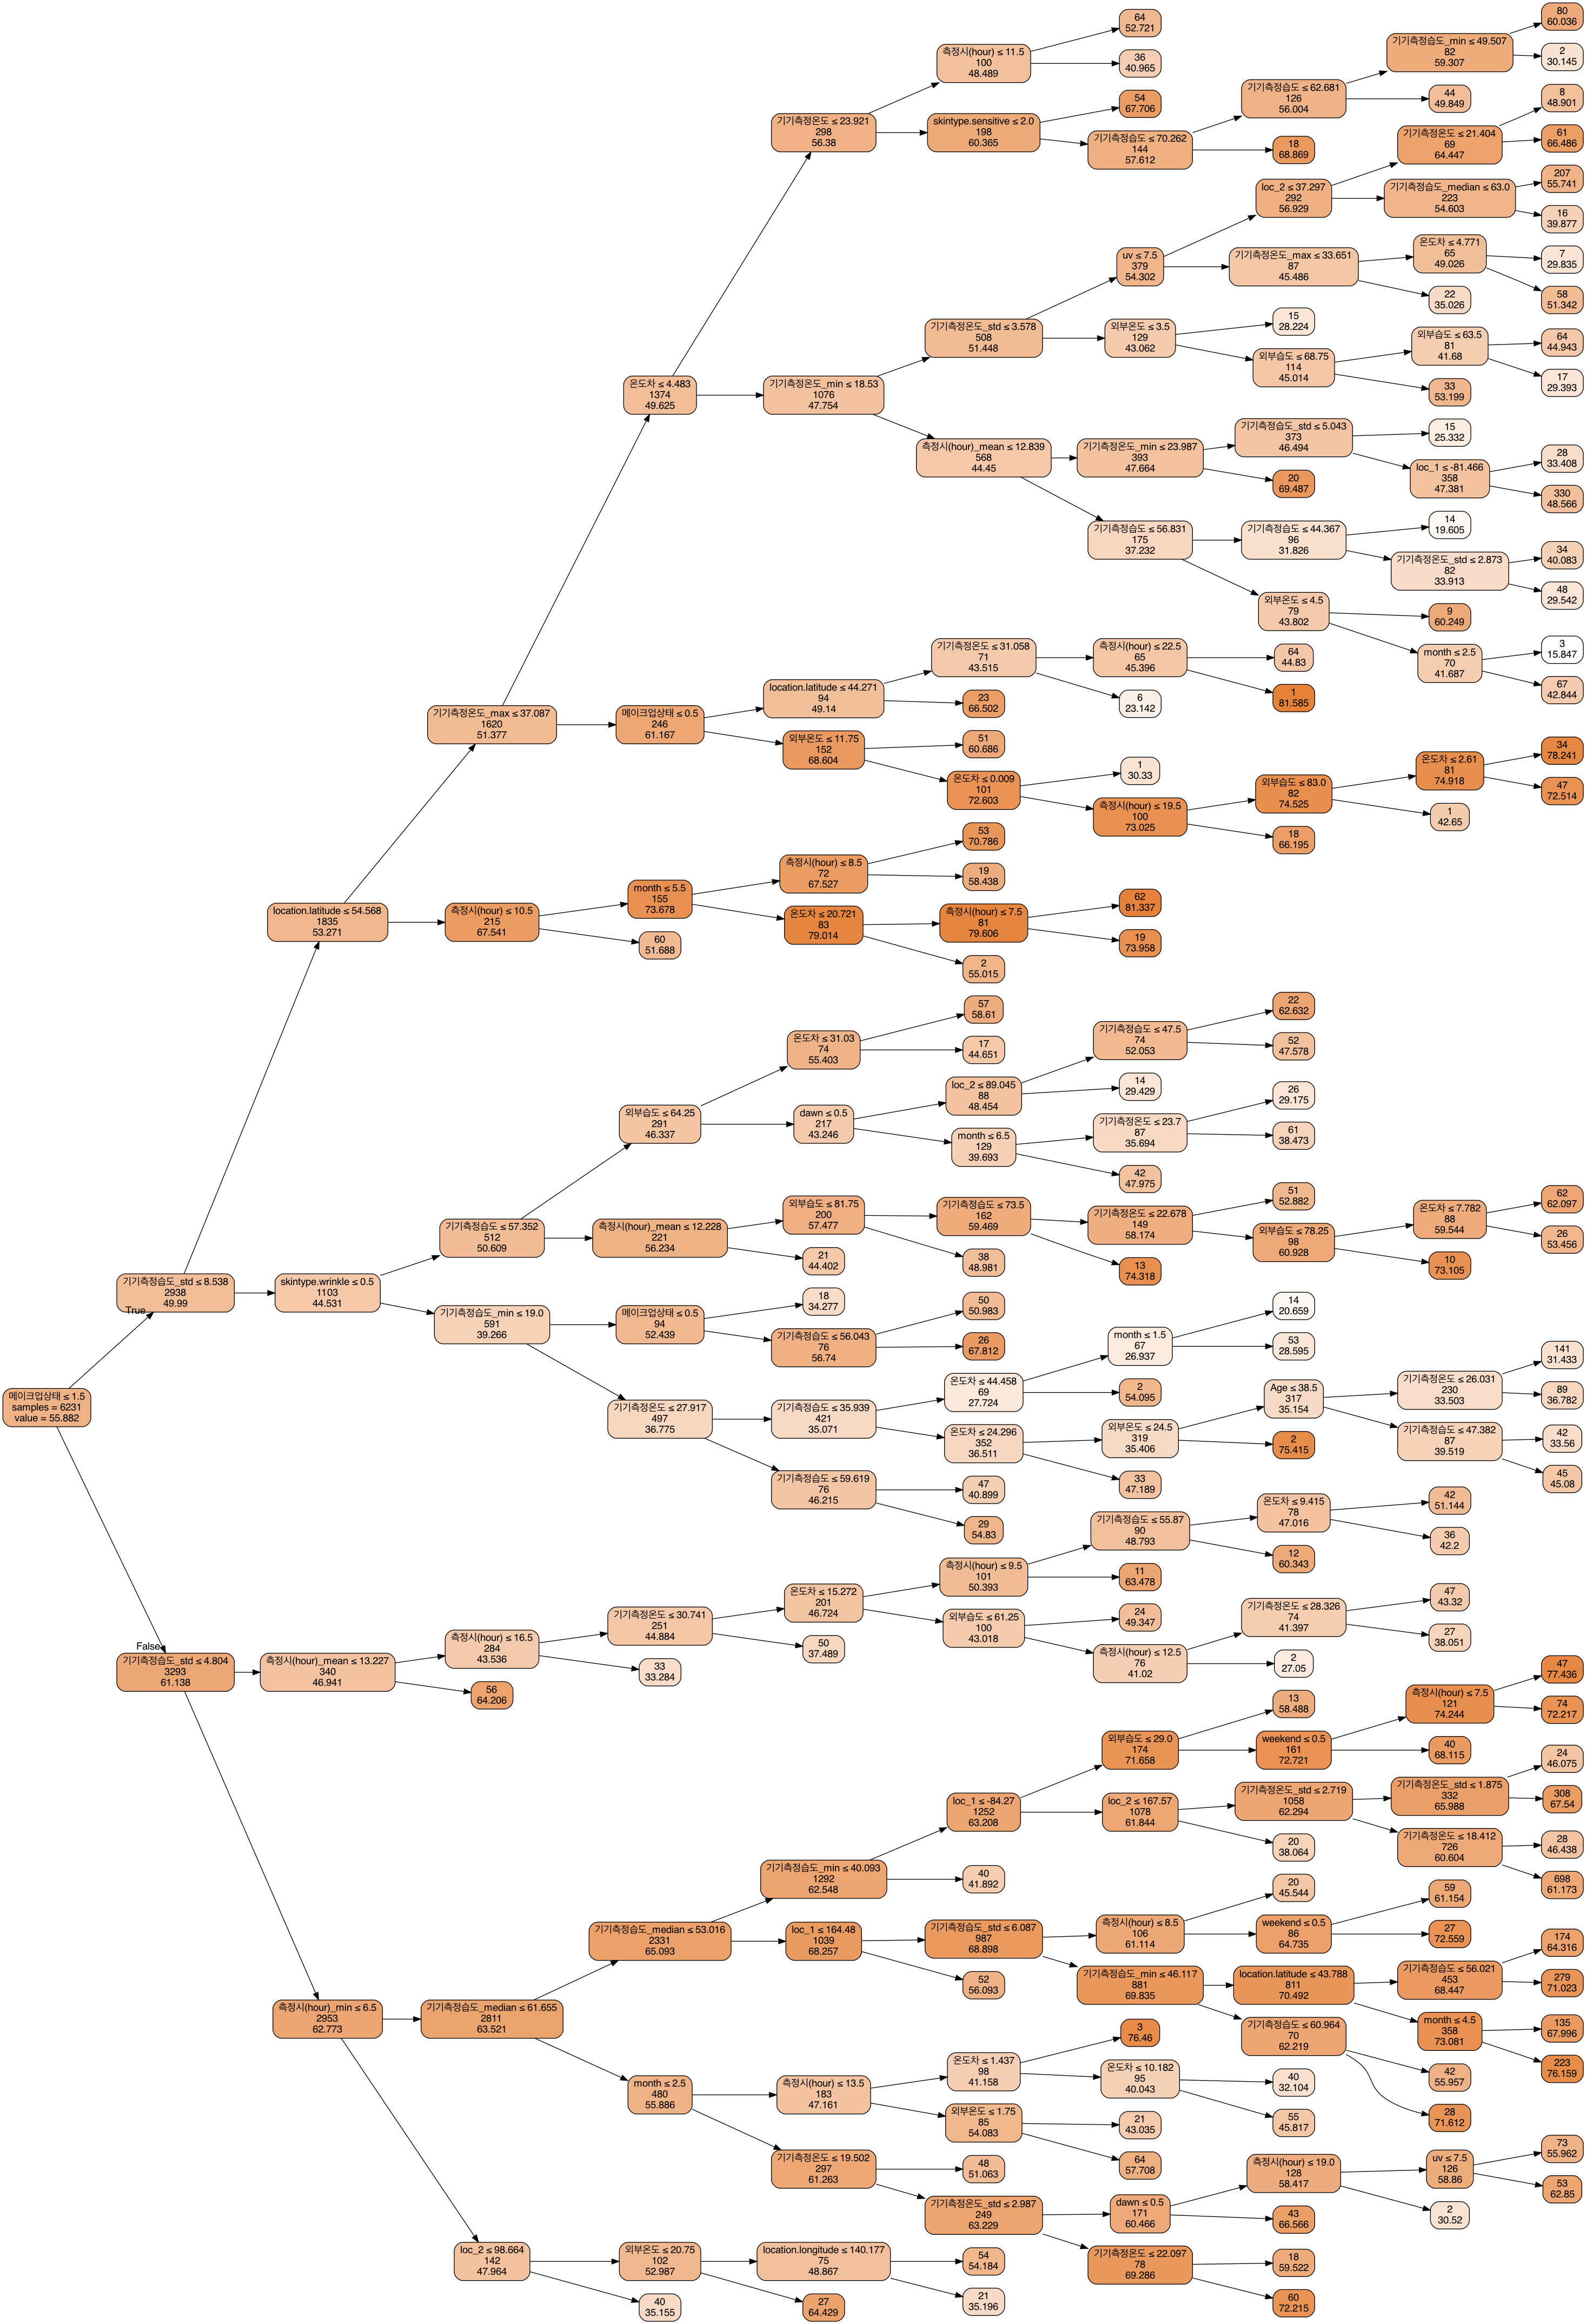

In [80]:
# plot the tree
plotDecisionTree(dt, feature_names=X_train.columns, rotate=True)

#### Feature importance : LGBM 

In [81]:
feature_list = pd.concat([pd.Series(X_train.columns), pd.Series(lgb.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:10]

,features_name,importance
29,NaN,2282
3,기기측정온도,2280
4,기기측정습도,2098
6,온도차,1840
36,NaN,1799
10,측정시(hour),1773
1,외부습도,1561
32,NaN,1346
2,외부온도,1273
20,기기측정온도_max,909


In [82]:
### 웨이스킨 측에서 의뢰한 피부수분지수에 유효한 변수들이 데이터베이스에 축적이 되고 있는지에 대한 부분에 대해서는, 그 유효성이 확인됨 
### LGBM Feature importance에 의하면 기기측정습도, 기기측정온도, 온도차, 측정시간, 피부습도, 피부온도 순으로 변수의 중요도가 높았음 
### 예측모델 결과 RMSE는 약 16, R-square 41 수준으로 측정되었음 
### 

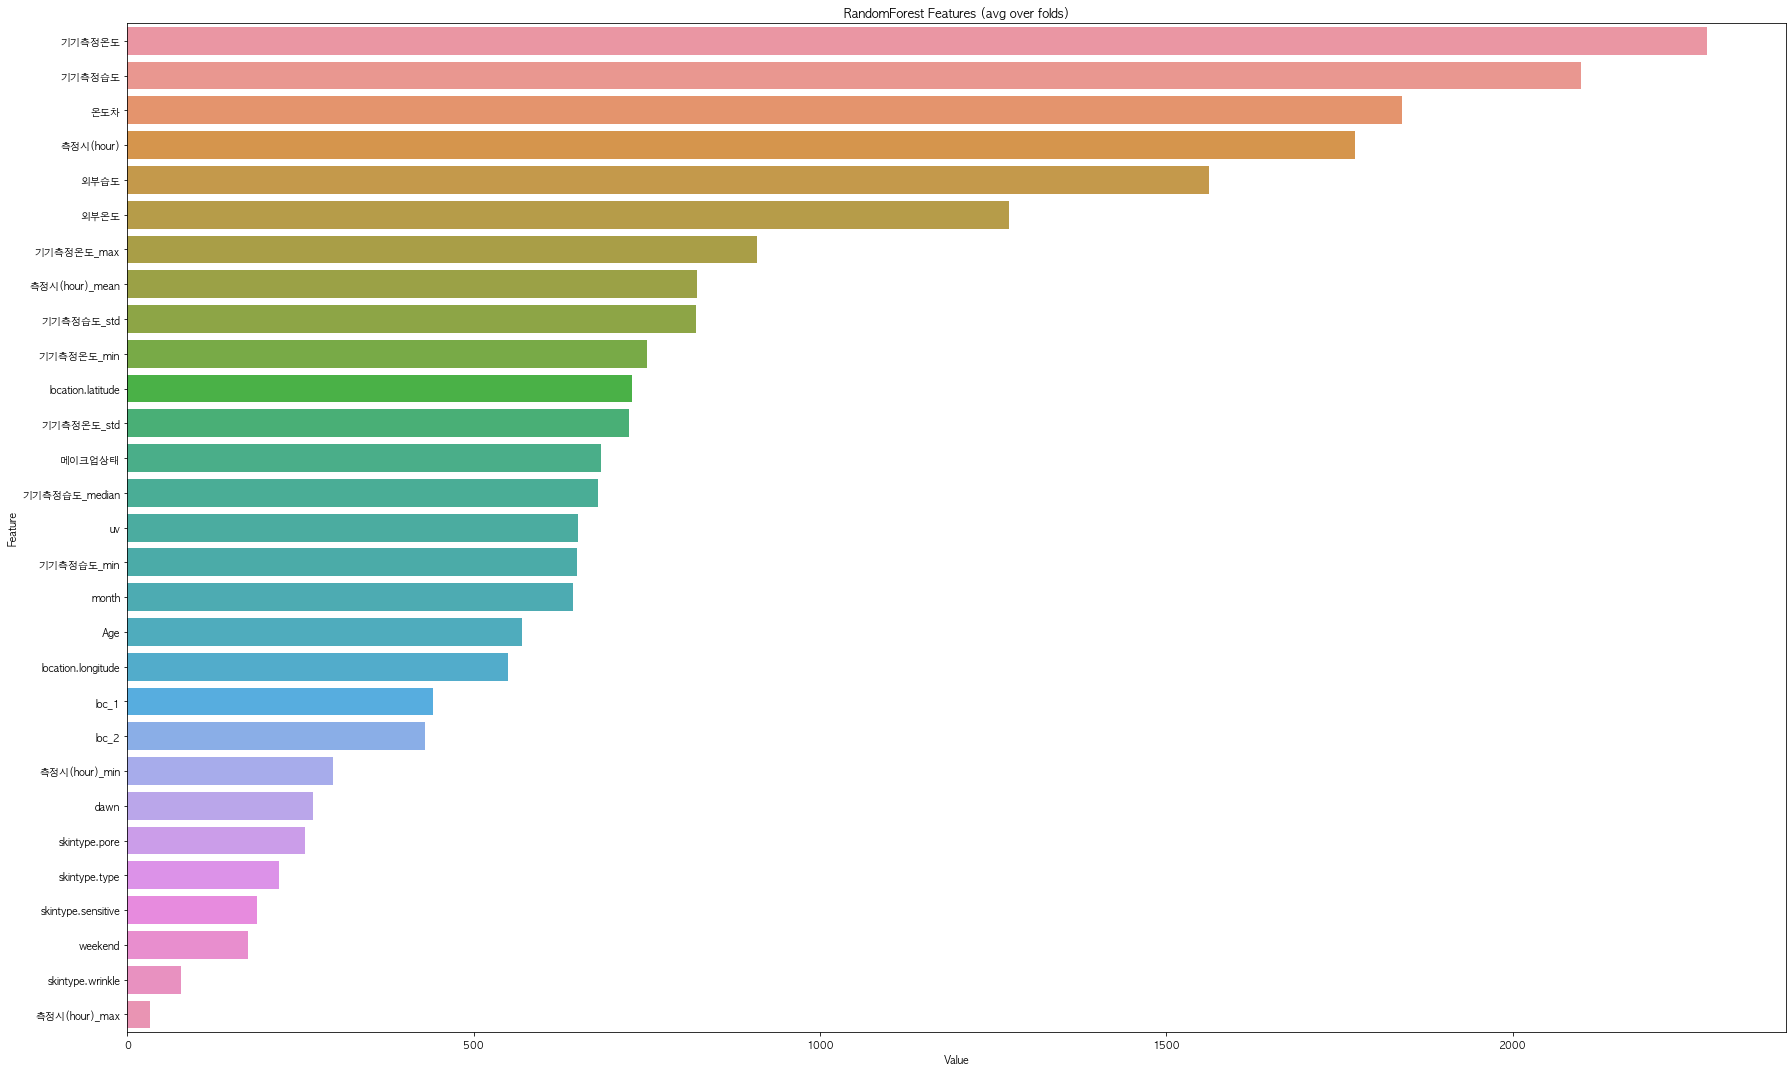

<Figure size 432x288 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(25, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForest Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')
plt.show()

<끝>